# Assignment 7


## Library Installation (Optional)


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    import sys
    !{sys.executable} -m pip install torchsummary

    # # Only if you want to automate receptive field calculation
    # if model_run_location == 'colab':
    #     !{sys.executable} -m pip install torchscan
    # elif model_run_location == 'local':
    #     %conda install --yes --prefix {sys.prefix} -c frgfm torchscan

    # # Needed locally
    # !conda install -c conda-forge tqdm
    # !conda install -c anaconda ipywidgets

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mount Drive


In [3]:
# Mount google drive if running on colab
if model_run_location == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 07/Submission

Mounted at /content/drive
/content/drive/MyDrive/WorkSpace/era-v1/Session 07/Submission


## Import Libraries


In [4]:
# Import necessary modules (external libs)
from __future__ import print_function

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from torchvision import transforms

In [5]:
# Import user defined modules
from model import Model06 as Net, plot_train_test_metrics, test_model, train_model
from utils import download_mnist_data, get_device, plot_sample_training_images

In [6]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()
print(f"Device created with {device_support}!")

Device created with cuda!


## Data Transformations


In [7]:
# Train and test data transformation steps now moved to apply_mnist_image_transformations()


def apply_mnist_image_transformations():
    """
    Function to apply the required transformations to the MNIST dataset.
    """
    # Apply the required transformations to the MNIST dataset
    train_transforms = transforms.Compose(
        [
            # Rotate the image by 6 degrees
            transforms.RandomRotation((-6.0, 6.0), fill=(0,)),
            # Convert the images to tensors
            # normalize the images with mean and standard deviation from the whole dataset
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )

    # Test data transformations
    test_transforms = transforms.Compose(
        # Convert the images to tensors
        # normalize the images with mean and standard deviation from the whole dataset
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    return train_transforms, test_transforms


train_transforms, test_transforms = apply_mnist_image_transformations()

## Train/Test Split


In [8]:
data_path = "../data"
print(f"Train and test data path: {data_path}")

train_data, test_data = download_mnist_data(
    data_path, train_transforms, test_transforms
)

Train and test data path: ../data


## Dataloaders


In [9]:
# Set seed value for reproducibility
seed = 1

# For reproducibility
torch.manual_seed(seed)

if device_support == "cuda":
    torch.cuda.manual_seed(seed)

batch_size = 32

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(
    shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

## Sample Training Images


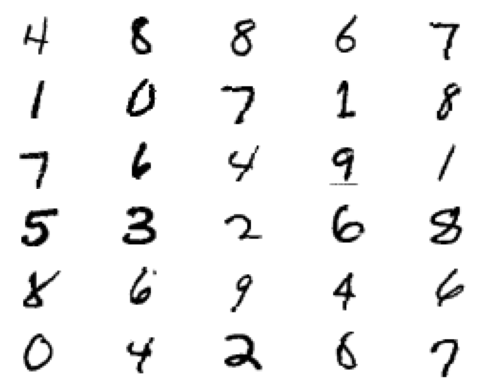

In [10]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 60 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig = plot_sample_training_images(batch_data, num_images=30)
plt.show()

## Model Summary


In [11]:
# Model class is imported from model.py

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# Print the model summary by specifying the input size
summary(model, input_size=(1, 28, 28))

# disable printing shape for cleaner test train output
model.print_shape = False

torch.Size([2, 8, 28, 28])
torch.Size([2, 10, 13, 13])
torch.Size([2, 12, 9, 9])
torch.Size([2, 16, 5, 5])
torch.Size([2, 10, 1, 1])
torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 10, 26, 26]             720
              ReLU-5           [-1, 10, 26, 26]               0
       BatchNorm2d-6           [-1, 10, 26, 26]              20
         MaxPool2d-7           [-1, 10, 13, 13]               0
            Conv2d-8           [-1, 10, 11, 11]             900
              ReLU-9           [-1, 10, 11, 11]               0
      BatchNorm2d-10           [-1, 10, 11, 11]              20
          Dropout-11           [-1, 10, 11, 11]               0
           Con

## Metric Initialisation


In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

## Train and Test


In [13]:
# Create optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Learning rate scheduler based on plateau
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=1,
    threshold=0.005,
    verbose=True
)

# Specify the number of epochs
num_epochs = 15

for epoch in range(1, num_epochs + 1):
    if epoch == 1:
        print(f"\n\nBatch size: {batch_size}, Total epochs: {num_epochs}\n\n")

    # Print the current epoch
    print(f"Epoch {epoch}")
    # Train the model
    train_model(model, device, train_loader, optimizer, train_acc, train_losses)
    # Test the model
    test_model(model, device, test_loader, test_acc, test_losses)
    # Passing the latest test loss in list to scheduler to adjust learning rate
    scheduler.step(test_losses[-1])
    # Line break before next epoch
    print("\n")



Batch size: 32, Total epochs: 15


Epoch 1


Train: Loss=0.0258, Batch_id=1874, Accuracy=96.28: 100%|██████████| 1875/1875 [00:35<00:00, 52.23it/s]


Test set: Average loss: 0.0463, Accuracy: 9846/10000 (98.46%)


Epoch 2


Train: Loss=0.0310, Batch_id=1874, Accuracy=98.37: 100%|██████████| 1875/1875 [00:34<00:00, 54.11it/s]


Test set: Average loss: 0.0353, Accuracy: 9883/10000 (98.83%)


Epoch 3


Train: Loss=0.0460, Batch_id=1874, Accuracy=98.64: 100%|██████████| 1875/1875 [00:33<00:00, 56.57it/s]


Test set: Average loss: 0.0334, Accuracy: 9898/10000 (98.98%)


Epoch 4


Train: Loss=0.0377, Batch_id=1874, Accuracy=98.82: 100%|██████████| 1875/1875 [00:33<00:00, 56.58it/s]


Test set: Average loss: 0.0299, Accuracy: 9912/10000 (99.12%)


Epoch 5


Train: Loss=0.0354, Batch_id=1874, Accuracy=98.95: 100%|██████████| 1875/1875 [00:33<00:00, 55.24it/s]


Test set: Average loss: 0.0271, Accuracy: 9911/10000 (99.11%)


Epoch 6


Train: Loss=0.0099, Batch_id=1874, Accuracy=99.06: 100%|██████████| 1875/1875 [00:34<00:00, 54.00it/s]


Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)


Epoch 7


Train: Loss=0.0024, Batch_id=1874, Accuracy=99.12: 100%|██████████| 1875/1875 [00:35<00:00, 52.92it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)


Epoch 8


Train: Loss=0.0636, Batch_id=1874, Accuracy=99.20: 100%|██████████| 1875/1875 [00:33<00:00, 55.52it/s]


Test set: Average loss: 0.0260, Accuracy: 9911/10000 (99.11%)


Epoch 9


Train: Loss=0.0177, Batch_id=1874, Accuracy=99.19: 100%|██████████| 1875/1875 [00:34<00:00, 54.68it/s]


Test set: Average loss: 0.0226, Accuracy: 9926/10000 (99.26%)
Epoch 00009: reducing learning rate of group 0 to 5.0000e-03.


Epoch 10


Train: Loss=0.0033, Batch_id=1874, Accuracy=99.44: 100%|██████████| 1875/1875 [00:34<00:00, 54.21it/s]


Test set: Average loss: 0.0204, Accuracy: 9939/10000 (99.39%)


Epoch 11


Train: Loss=0.0718, Batch_id=1874, Accuracy=99.47: 100%|██████████| 1875/1875 [00:34<00:00, 54.82it/s]


Test set: Average loss: 0.0203, Accuracy: 9935/10000 (99.35%)


Epoch 12


Train: Loss=0.2157, Batch_id=1874, Accuracy=99.49: 100%|██████████| 1875/1875 [00:34<00:00, 53.80it/s]


Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)


Epoch 13


Train: Loss=0.0003, Batch_id=1874, Accuracy=99.48: 100%|██████████| 1875/1875 [00:32<00:00, 57.40it/s]


Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)


Epoch 14


Train: Loss=0.0249, Batch_id=1874, Accuracy=99.51: 100%|██████████| 1875/1875 [00:37<00:00, 50.67it/s]


Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)
Epoch 00014: reducing learning rate of group 0 to 2.5000e-03.


Epoch 15


Train: Loss=0.0095, Batch_id=1874, Accuracy=99.63: 100%|██████████| 1875/1875 [00:32<00:00, 57.49it/s]


Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)




## Metrics


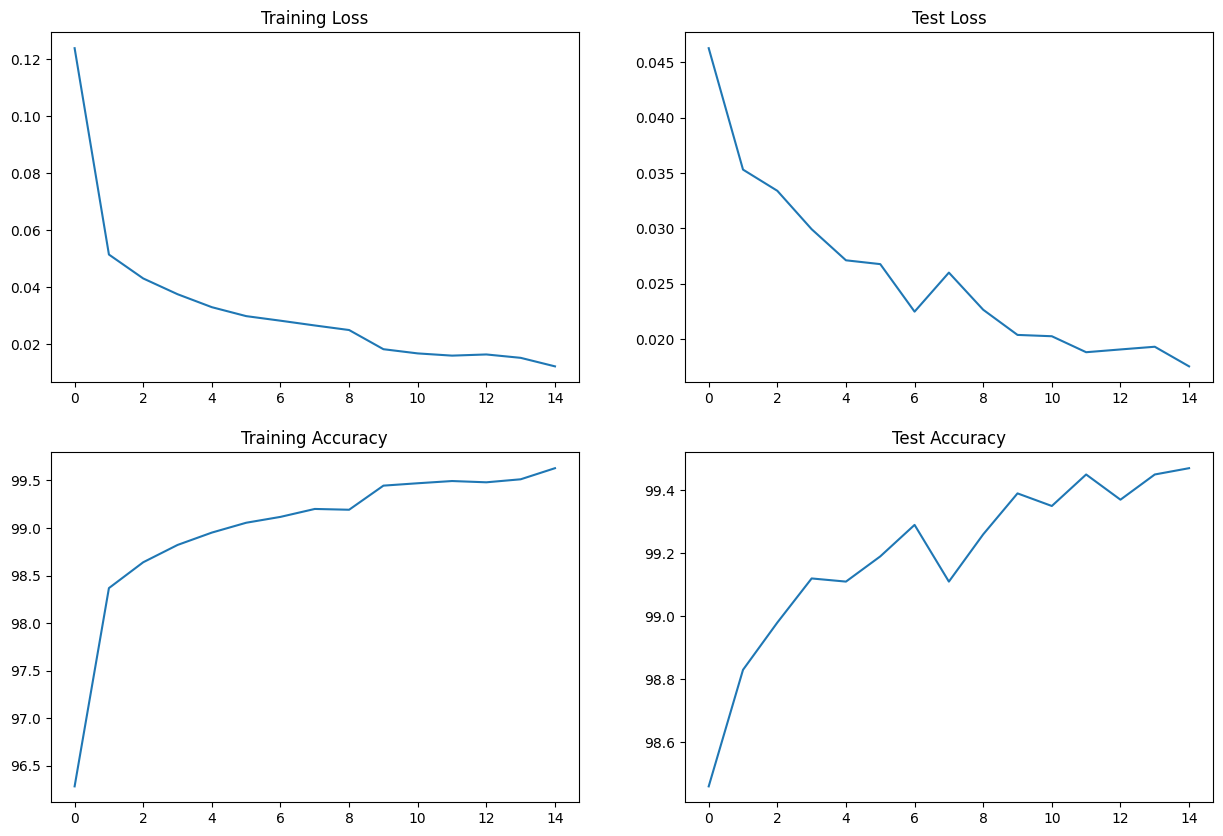

In [14]:
# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
fig, axs = plot_train_test_metrics(train_losses, train_acc, test_losses, test_acc)
plt.show()